# 使用torch.nn实现逻辑回归

In [3]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  #防止jupyter崩溃

## 1 人工构造数据集

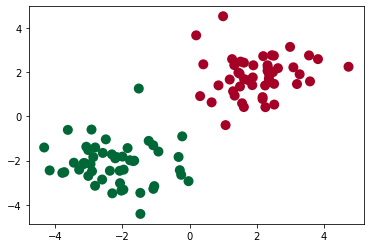

In [4]:
#自定义数据训练集 一共100个数据
n_data = torch.ones(50, 2) # 数据的基本形态
x1 = torch.normal(2 * n_data, 1) # shape=(50, 2)
y1 = torch.zeros(50) # 类型0 shape=(50, 1)
x2 = torch.normal(-2 * n_data, 1) # shape=(50, 2)
y2 = torch.ones(50) # 类型1 shape=(50, 1)
# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据)
trainfeatures = torch.cat((x1, x2), 0).type(torch.FloatTensor) #trainfeatures
trainlabels = torch.cat((y1, y2), 0).type(torch.FloatTensor) #trainlabels
#可视化
plt.scatter(trainfeatures.data.numpy()[:, 0], trainfeatures.data.numpy()[:, 1], c=trainlabels.data.numpy(), s=100, lw=0,
cmap='RdYlGn')

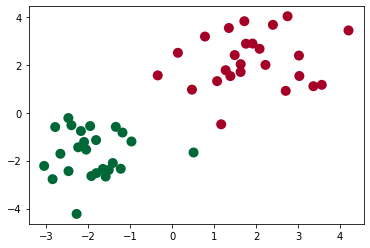

In [5]:
#自定义数据-测试集
n_data = torch.ones(25, 2) # 数据的基本形态
x1 = torch.normal(2 * n_data, 1) # shape=(25, 2)
y1 = torch.zeros(25) # 类型0 shape=(25, 1)
x2 = torch.normal(-2 * n_data, 1) # shape=(25, 2)
y2 = torch.ones(25) # 类型1 shape=(50, 1)
# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据)
testfeatures = torch.cat((x1, x2), 0).type(torch.FloatTensor) #trainfeatures
testlabels = torch.cat((y1, y2), 0).type(torch.FloatTensor) #trainlabels
#可视化
plt.scatter(testfeatures.data.numpy()[:, 0], testfeatures.data.numpy()[:, 1], c=testlabels.data.numpy(), s=100, lw=0,
cmap='RdYlGn')
#随机生成了100个数据作为训练集，前50个作为正样本标签为1，值为正，后50个为负，标签0
#随机生成50个数据集作为测试集，同上

## 2 定义模型

In [6]:
#利用torch. utils.data读取数据集
#读取数据
import torch.utils.data as Data
import torch.nn as nn
batch_size = 5
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(trainfeatures, trainlabels)
# 把 dataset 放入 DataLoader
data_iter = Data.DataLoader(
    dataset=dataset, # torch TensorDataset format
    batch_size=batch_size, # mini batch size
    shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱)
    num_workers=0, # 多线程来读数据， 注意在Windows下需要设置为0
)
# 将测试数据的特征和标签组合
dataset = Data.TensorDataset(testfeatures, testlabels)
# 把 dataset 放入 DataLoader
test_data_iter = Data.DataLoader(
	    dataset=dataset, # torch TensorDataset format
	    batch_size=batch_size, # mini batch size
	    shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱)
	    num_workers=0, # 多线程来读数据， 注意在Windows下需要设置为0
)

class LogisticRegression(nn.Module):
    def __init__(self, n_features):
        super(LogisticRegression, self).__init__()
        self.lr = nn.Linear(n_features, 1)
        self.sm = nn.Sigmoid()

    def forward(self, x):
        x = self.lr(x)
        x = self.sm(x)
        return x
    
#初始化模型
logistic_model = LogisticRegression(2)

## 3 定义损失函数和优化器

In [8]:
#定义损失函数
criterion = nn.BCELoss()
#定义优化器
optimizer = torch.optim.SGD(logistic_model.parameters(), lr=1e-3)
#参数初始化
nn.init.normal_(logistic_model.lr.weight, mean=0, std=0.01)
nn.init.constant_(logistic_model.lr.bias, val=0) #也可以直接修改bias的data： net[0].bias.data.fill_(0)
print(logistic_model.lr.weight)
print(logistic_model.lr.bias)

#定义测试集准确率函数
def evaluate_accuracy():
    acc_sum,n = 0.0,0
    for X,y in test_data_iter:
        #print(len(X)) 小批量数据集 每个X中有 256个图像
        #print((net(X).argmax(dim=1)==y).float().sum().item())
        y_hat = logistic_model(X)
        y_hat = torch.squeeze(torch.where(y_hat>0.5,torch.tensor(1.0),torch.tensor(0.0)))
        acc_sum += (y_hat==y).float().sum().item()
        n+=y.shape[0]
    return acc_sum/n

Parameter containing:
tensor([[-0.0089, -0.0078]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


## 4 训练模型

In [10]:
#开始训练
num_epochs = 300
epochlist = np.arange(1,num_epochs+1)
losslist = []
for epoch in range( num_epochs):
    train_l_num, train_acc_num,n = 0.0,0.0,0
    for X, y in data_iter:
        y_hat = logistic_model(X)
        l = criterion(y_hat, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于logistic_model.zero_grad()
        l.backward()
        # update model parameters
        optimizer.step()
        #计算每个epoch的loss
        train_l_num += l.item()
        #计算训练样本的准确率
        y_hat = torch.squeeze(torch.where(y_hat>0.5,torch.tensor(1.0),torch.tensor(0.0)))
        train_acc_num += (y_hat==y).sum().item()
        #每一个epoch的所有样本数
        n+= y.shape[0]
    #计算测试样本的准确率
    test_acc = evaluate_accuracy()
    print('epoch %d, loss %.4f,train_acc %f,test_acc %f'%(epoch+1,train_l_num/n, train_acc_num/n, test_acc))
    losslist.append(train_l_num/n)

epoch 1, loss 0.0091,train_acc 1.000000,test_acc 1.000000
epoch 2, loss 0.0091,train_acc 1.000000,test_acc 1.000000
epoch 3, loss 0.0091,train_acc 1.000000,test_acc 1.000000
epoch 4, loss 0.0090,train_acc 1.000000,test_acc 1.000000
epoch 5, loss 0.0090,train_acc 1.000000,test_acc 1.000000
epoch 6, loss 0.0090,train_acc 1.000000,test_acc 1.000000
epoch 7, loss 0.0090,train_acc 1.000000,test_acc 1.000000
epoch 8, loss 0.0090,train_acc 1.000000,test_acc 1.000000
epoch 9, loss 0.0089,train_acc 1.000000,test_acc 1.000000
epoch 10, loss 0.0089,train_acc 1.000000,test_acc 1.000000
epoch 11, loss 0.0089,train_acc 1.000000,test_acc 1.000000
epoch 12, loss 0.0089,train_acc 1.000000,test_acc 1.000000
epoch 13, loss 0.0089,train_acc 1.000000,test_acc 1.000000
epoch 14, loss 0.0088,train_acc 1.000000,test_acc 1.000000
epoch 15, loss 0.0088,train_acc 1.000000,test_acc 1.000000
epoch 16, loss 0.0088,train_acc 1.000000,test_acc 1.000000
epoch 17, loss 0.0088,train_acc 1.000000,test_acc 1.000000
epoch 

epoch 149, loss 0.0071,train_acc 1.000000,test_acc 1.000000
epoch 150, loss 0.0071,train_acc 1.000000,test_acc 1.000000
epoch 151, loss 0.0070,train_acc 1.000000,test_acc 1.000000
epoch 152, loss 0.0070,train_acc 1.000000,test_acc 1.000000
epoch 153, loss 0.0070,train_acc 1.000000,test_acc 1.000000
epoch 154, loss 0.0070,train_acc 1.000000,test_acc 1.000000
epoch 155, loss 0.0070,train_acc 1.000000,test_acc 1.000000
epoch 156, loss 0.0070,train_acc 1.000000,test_acc 1.000000
epoch 157, loss 0.0070,train_acc 1.000000,test_acc 1.000000
epoch 158, loss 0.0070,train_acc 1.000000,test_acc 1.000000
epoch 159, loss 0.0070,train_acc 1.000000,test_acc 1.000000
epoch 160, loss 0.0070,train_acc 1.000000,test_acc 1.000000
epoch 161, loss 0.0069,train_acc 1.000000,test_acc 1.000000
epoch 162, loss 0.0069,train_acc 1.000000,test_acc 1.000000
epoch 163, loss 0.0069,train_acc 1.000000,test_acc 1.000000
epoch 164, loss 0.0069,train_acc 1.000000,test_acc 1.000000
epoch 165, loss 0.0069,train_acc 1.00000

epoch 289, loss 0.0060,train_acc 1.000000,test_acc 1.000000
epoch 290, loss 0.0060,train_acc 1.000000,test_acc 1.000000
epoch 291, loss 0.0060,train_acc 1.000000,test_acc 1.000000
epoch 292, loss 0.0060,train_acc 1.000000,test_acc 1.000000
epoch 293, loss 0.0060,train_acc 1.000000,test_acc 1.000000
epoch 294, loss 0.0060,train_acc 1.000000,test_acc 1.000000
epoch 295, loss 0.0059,train_acc 1.000000,test_acc 1.000000
epoch 296, loss 0.0059,train_acc 1.000000,test_acc 1.000000
epoch 297, loss 0.0059,train_acc 1.000000,test_acc 1.000000
epoch 298, loss 0.0059,train_acc 1.000000,test_acc 1.000000
epoch 299, loss 0.0059,train_acc 1.000000,test_acc 1.000000
epoch 300, loss 0.0059,train_acc 1.000000,test_acc 1.000000


## 5 结果可视化

In [ ]:
import matplotlib as plt

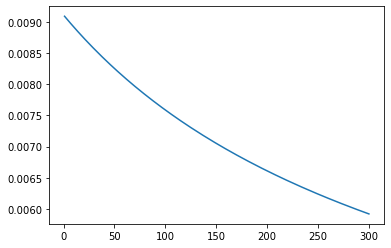

In [11]:
plt.plot(epochlist,losslist)